In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
import string
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
import ast
from sklearn.model_selection import train_test_split 
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
# Binary Relevance
from sklearn.multiclass import OneVsRestClassifier
# Performance metric
from sklearn.metrics import f1_score
# Import Joblib Module from Scikit Learn
from sklearn.externals import joblib

C:\Users\DINA\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [2]:
data= pd.read_csv("jobs_data.csv")

In [3]:
data.head()

,Unnamed: 0,title,jobFunction,industry
0,0,Full Stack PHP Developer,"['Engineering - Telecom/Technology', 'IT/Softw...","['Computer Software', 'Marketing and Advertisi..."
1,1,CISCO Collaboration Specialist Engineer,"['Installation/Maintenance/Repair', 'IT/Softwa...",['Information Technology Services']
2,2,Senior Back End-PHP Developer,"['Engineering - Telecom/Technology', 'IT/Softw...","['Computer Software', 'Computer Networking']"
3,3,UX Designer,"['Creative/Design/Art', 'IT/Software Developme...","['Computer Software', 'Information Technology ..."
4,4,Java Technical Lead,"['Engineering - Telecom/Technology', 'IT/Softw...","['Computer Software', 'Information Technology ..."


In [4]:
data=data.drop(['Unnamed: 0'],axis=1)

In [5]:
#check for null values
data[data.isnull()].count()

title          0
jobFunction    0
industry       0
dtype: int64

In [6]:
data[data['jobFunction'] == "['nan']"].count()

title          117
jobFunction    117
industry       117
dtype: int64

In [7]:
# replace nan values with jobFunctions if they have the same title
df_nan=data[data['jobFunction'] == "['nan']"]# dataframe contain null values
for index, row in df_nan.iterrows():
    newDF = data[data['title'] == row['title']]
    if newDF.iloc[-1,1] != "['nan']" :
        data.at[index,'jobFunction']= newDF.iloc[-1,1]

In [8]:
# Remove missing values (NaN)
data=data[data['jobFunction'] != "['nan']"]

In [9]:
# To read jobFunction as list instead of string 
data['jobFunction']= [ast.literal_eval(i) for i in data['jobFunction']]

In [10]:
# Taking Out all the jobFunctions in the dataset and storing in a list
#jobFunctions = [[i for i in row] for row in data.jobFunction]
jobFunctions=[]
for _ ,row in data.iterrows():
    for i in row.jobFunction :
        jobFunctions.append(i)

In [11]:
#unique(jobFunctions list): 
uniquejobFunctions = np.unique(np.array(jobFunctions)).tolist()

In [12]:
len(uniquejobFunctions)

37

In [13]:
print(uniquejobFunctions)

['Accounting/Finance', 'Administration', 'Analyst/Research', 'Banking', 'Business Development', 'C-Level Executive/GM/Director', 'Creative/Design/Art', 'Customer Service/Support', 'Education/Teaching', 'Engineering - Construction/Civil/Architecture', 'Engineering - Mechanical/Electrical', 'Engineering - Oil & Gas/Energy', 'Engineering - Other', 'Engineering - Telecom/Technology', 'Fashion', 'Hospitality/Hotels/Food Services', 'Human Resources', 'IT/Software Development', 'Installation/Maintenance/Repair', 'Legal', 'Logistics/Supply Chain', 'Manufacturing/Production', 'Marketing/PR/Advertising', 'Media/Journalism/Publishing', 'Medical/Healthcare', 'Operations/Management', 'Pharmaceutical', 'Project/Program Management', 'Purchasing/Procurement', 'Quality', 'R&D/Science', 'Sales/Retail', 'Sports and Leisure', 'Strategy/Consulting', 'Tourism/Travel', 'Training/Instructor', 'Writing/Editorial']


In [14]:
#dictionary of jobfunctions and their occurrence count across the dataset
jobFunctions = nltk.FreqDist(jobFunctions) 

# create dataframe
jobFunctions_df = pd.DataFrame({'jobFunction': list(jobFunctions.keys()), 
                              'Count': list(jobFunctions.values())})

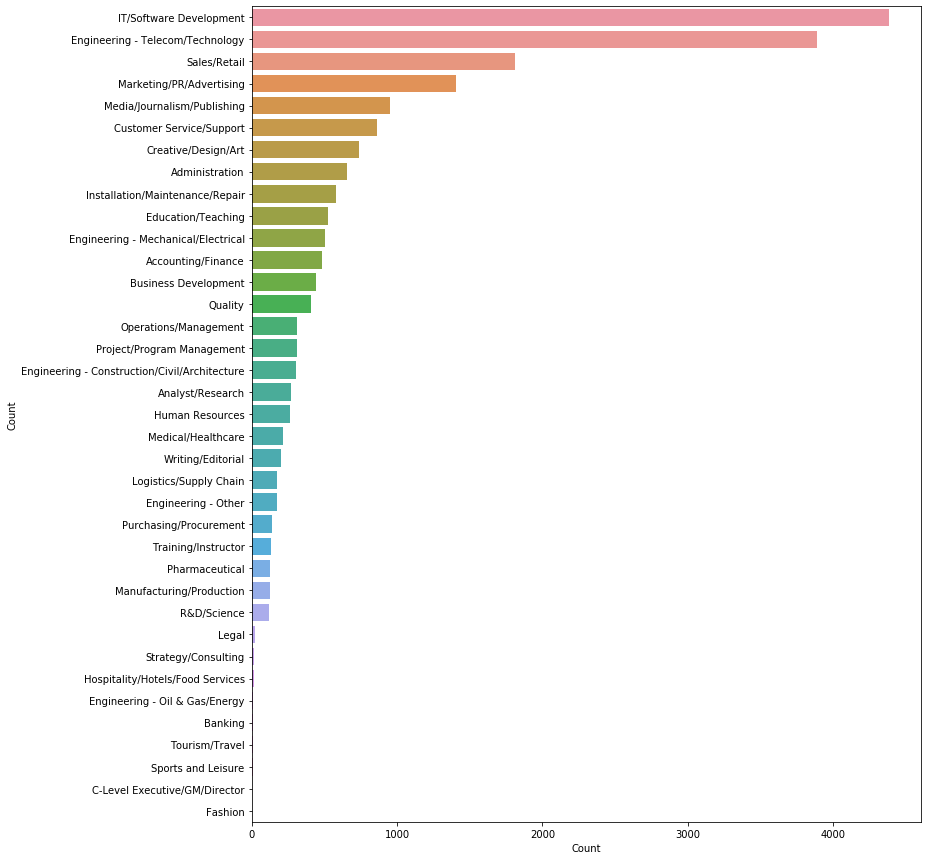

In [15]:
import seaborn as sns
g = jobFunctions_df.nlargest(columns="Count", n = 50) 
plt.figure(figsize=(12,15)) 
ax = sns.barplot(data=g, x= "Count", y = "jobFunction") 
ax.set(ylabel = 'Count') 
plt.show()

In [16]:
# function for text cleaning 
def clean_text(text):
    # remove backslash-apostrophe 
    text = re.sub("\'", "", text) 
    # remove everything except alphabets 
    text = re.sub("[^a-zA-Z]"," ",text) 
    # remove whitespaces 
    text = ' '.join(text.split()) 
    # convert text to lowercase 
    text = text.lower() 
    ws=nltk.WordNetLemmatizer()
    text=ws.lemmatize(text)
    return text

In [17]:
data['clean_title'] = data['title'].apply(lambda x: clean_text(x))

In [18]:
data.head()

,title,jobFunction,industry,clean_title
0,Full Stack PHP Developer,"[Engineering - Telecom/Technology, IT/Software...","['Computer Software', 'Marketing and Advertisi...",full stack php developer
1,CISCO Collaboration Specialist Engineer,"[Installation/Maintenance/Repair, IT/Software ...",['Information Technology Services'],cisco collaboration specialist engineer
2,Senior Back End-PHP Developer,"[Engineering - Telecom/Technology, IT/Software...","['Computer Software', 'Computer Networking']",senior back end php developer
3,UX Designer,"[Creative/Design/Art, IT/Software Development]","['Computer Software', 'Information Technology ...",ux designer
4,Java Technical Lead,"[Engineering - Telecom/Technology, IT/Software...","['Computer Software', 'Information Technology ...",java technical lead


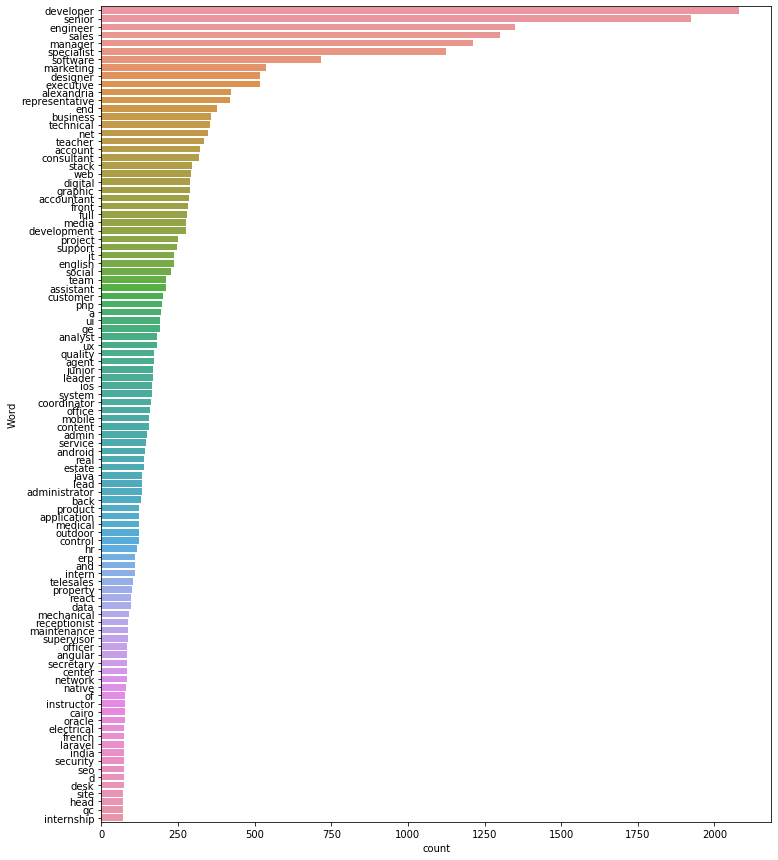

In [19]:
#The function below will visualize the words and their frequency 
def freq_words(x, terms = 30): 
  all_words = ' '.join([text for text in x]) 
  all_words = all_words.split() 
  fdist = nltk.FreqDist(all_words) 
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 
  
  # selecting top 20 most frequent words 
  d = words_df.nlargest(columns="count", n = terms) 
  
  # visualize words and frequencies
  plt.figure(figsize=(12,15)) 
  ax = sns.barplot(data=d, x= "count", y = "word") 
  ax.set(ylabel = 'Word') 
  plt.show()
  
# print 100 most frequent words 
freq_words(data['clean_title'], 100)

In [20]:
#I want to know some of citis names to remove it stopwords
data[data['title'].str.contains("City")]

,title,jobFunction,industry,clean_title
82,Secretary - Nasr City,[Administration],['Real Estate/Property Management'],secretary nasr city
170,Assistant Manager Security - Cairo Festival Ci...,[Administration],"['Real Estate/Property Management', 'Construct...",assistant manager security cairo festival city...
219,Flutter Developer - Nasr City,"[IT/Software Development, Engineering - Teleco...",['Information Technology Services'],flutter developer nasr city
831,Graphic Designer | IKEA | Cairo Festival City,"[IT/Software Development, Creative/Design/Art]",['Construction - Residential & Commercial/Offi...,graphic designer ikea cairo festival city
850,Quality Control Specialist - Alsadat City,"[R&D/Science, Quality]",['Manufacturing'],quality control specialist alsadat city
...,...,...,...,...
9937,Electrical Engineer - Sadat City,[Engineering - Mechanical/Electrical],['Manufacturing'],electrical engineer sadat city
10001,English Language Instructor - Nasr City/Sheraton,"[Education/Teaching, Training/Instructor]",['Education'],english language instructor nasr city sheraton
10128,Front and Reception Officer / Nasr City,"[Administration, Customer Service/Support]",['Education'],front and reception officer nasr city
10328,Sales Representative - Nasr City,[Sales/Retail],"['Computer Software', 'Computer Games', 'Compu...",sales representative nasr city


In [21]:
#nltk.download('stopwords')

In [22]:
#remove the stopwords
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
new_word = ['internship','intern', 'part', 'time','junior','senior'
            ,'cairo','alexandria','assiut','nasr','banha','city','festival'
            ,'sheraton','heliopolis','dubai', 'festival','mall','shorouk',
            'branche','th','sadat','ramadan','alsadat','new','american', 
            'school','qalubia','sharqia','tanta','KSA','indonesia','uae', 
            'national', 'ikea' ,'hurghada','saudi' ,'arabia','alex','dammam',
            'tunis','egypt','only','male','female']
stop_words = stop_words.union(new_word) 

# function to remove stopwords
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)

data['clean_title'] = data['clean_title'].apply(lambda x: remove_stopwords(x))


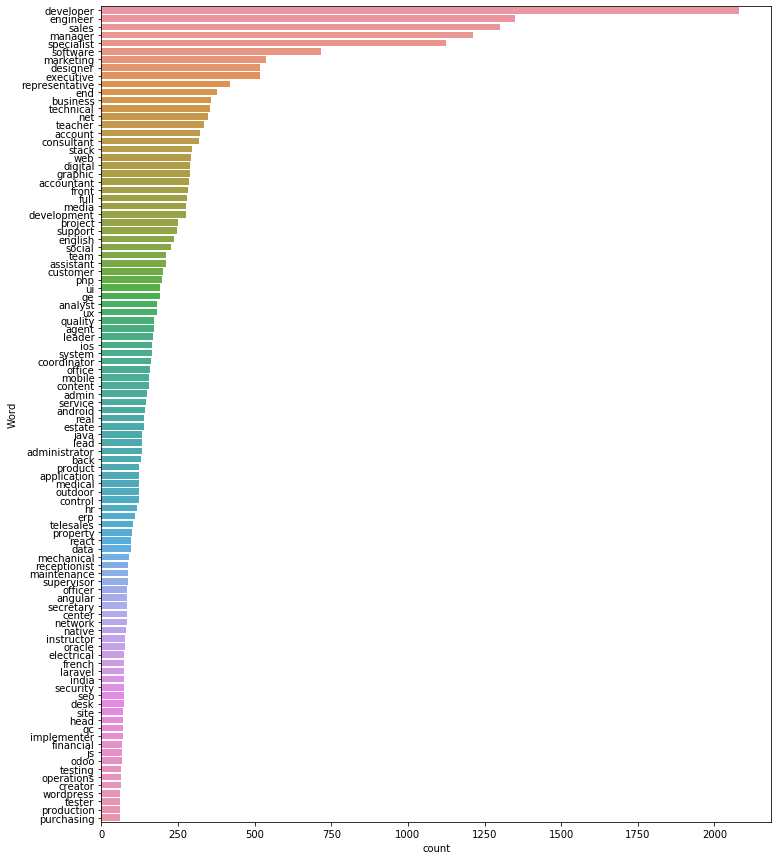

In [23]:
freq_words(data['clean_title'], 100)

In [24]:
#one hot encode the target variable to 37 new target variables
from sklearn.preprocessing import MultiLabelBinarizer

multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(data['jobFunction'])

# transform target variable
y = multilabel_binarizer.transform(data['jobFunction'])

In [25]:
#feature extraction by tf_idf
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=1000)

In [26]:
# split dataset into training and validation set
xtrain, xval, ytrain, yval = train_test_split(data['clean_title'], y, test_size=0.2, random_state=9)

In [27]:
# create TF-IDF features
xtrain_tfidf = tfidf_vectorizer.fit_transform(xtrain)
xval_tfidf = tfidf_vectorizer.transform(xval)

In [28]:
lr = LogisticRegression()
clf = OneVsRestClassifier(lr)

In [29]:
# fit model on train data
clf.fit(xtrain_tfidf, ytrain)

OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False),
                    n_jobs=None)

In [30]:
# make predictions for validation set
y_pred = clf.predict(xval_tfidf)

In [31]:
y_pred[3]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [32]:
multilabel_binarizer.inverse_transform(y_pred)[3]

('Engineering - Telecom/Technology', 'IT/Software Development')

In [33]:
# evaluate performance
f1_score(yval, y_pred, average="micro")
#from sklearn.metrics import classification_report
#classification_report(yval[0], y_pred[0])

0.8230352303523035

In [34]:
def infer_tags(q):
    q = clean_text(q)
    q = remove_stopwords(q)
    q_vec = tfidf_vectorizer.transform([q])
    q_pred = clf.predict(q_vec)
    return multilabel_binarizer.inverse_transform(q_pred)

In [35]:
infer_tags('teacher')

[('Education/Teaching',)]

In [36]:
for i in range(5): 
  k = xval.sample(1).index[0] 
  print("Title: ", data['title'][k], "\nPredicted job Function: ", infer_tags(xval[k])), print("Actual job Function: ",data['jobFunction'][k], "\n")


Title:  Ionic Application Developer (Hybrid Mobile Applications) 
Predicted job Function:  [('Engineering - Telecom/Technology', 'IT/Software Development')]
Actual job Function:  ['IT/Software Development', 'Engineering - Telecom/Technology'] 

Title:  Sales Account Manager 
Predicted job Function:  [('Sales/Retail',)]
Actual job Function:  ['Marketing/PR/Advertising', 'Sales/Retail', 'Customer Service/Support'] 

Title:  Civil / Architecture Technical Office Engineer 
Predicted job Function:  [('Engineering - Construction/Civil/Architecture',)]
Actual job Function:  ['Engineering - Construction/Civil/Architecture'] 

Title:  Senior Production Engineer 
Predicted job Function:  [('Engineering - Mechanical/Electrical', 'Manufacturing/Production')]
Actual job Function:  ['Engineering - Mechanical/Electrical', 'Manufacturing/Production'] 

Title:  Marketing Specialist - Educational 
Predicted job Function:  [('Marketing/PR/Advertising', 'Media/Journalism/Publishing')]
Actual job Function:

In [37]:
# Save the Model to file in the current working directory
joblib.dump(clf, 'LogisticModel1.pkl')
# load the Model
clf = joblib.load('LogisticModel1.pkl')

Another model

In [38]:
multinomial = MultinomialNB(fit_prior=True, class_prior=None)
clf = OneVsRestClassifier(multinomial)
# fit model on train data
clf.fit(xtrain_tfidf, ytrain)
# make predictions for validation set
y_pred = clf.predict(xval_tfidf)

In [39]:
y_pred[3]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [40]:
multilabel_binarizer.inverse_transform(y_pred)[3]

('Engineering - Telecom/Technology', 'IT/Software Development')

In [41]:
f1_score(yval, y_pred, average="micro")

0.8152099575981397

In [42]:
for i in range(5): 
  k = xval.sample(1).index[0] 
  print("Title: ", data['title'][k], "\nPredicted job Function: ", infer_tags(xval[k])), print("Actual job Function: ",data['jobFunction'][k], "\n")


Title:  Senior .NET Developer 
Predicted job Function:  [('Engineering - Telecom/Technology', 'IT/Software Development')]
Actual job Function:  ['IT/Software Development', 'Engineering - Telecom/Technology'] 

Title:  Magento Developer 
Predicted job Function:  [('Engineering - Telecom/Technology', 'IT/Software Development')]
Actual job Function:  ['Engineering - Telecom/Technology', 'IT/Software Development'] 

Title:  Senior UI/UX Graphic Designer 
Predicted job Function:  [('Creative/Design/Art', 'IT/Software Development')]
Actual job Function:  ['IT/Software Development', 'Engineering - Telecom/Technology', 'Creative/Design/Art'] 

Title:  Senior Quality Control Engineer 
Predicted job Function:  [('Engineering - Telecom/Technology', 'IT/Software Development', 'Quality')]
Actual job Function:  ['IT/Software Development', 'Engineering - Telecom/Technology', 'Quality'] 

Title:  Full Stack Developer 
Predicted job Function:  [('Engineering - Telecom/Technology', 'IT/Software Developm